# Filtered Projections & Reconstruction from filtered projections



In [1]:
import sys, os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.getcwd(), 'modules'))
from RadonUtils import backprojection2

In [2]:
fname_sino = './sinograms/sinogram_stripes.npz'
npzData = np.load(fname_sino)
print(f"npzData.files: {npzData.files}")

npzData.files: ['N_theta', 'theta_vec_deg', 't_vec', 'sinogram']


In [3]:
# get the data
N_theta = npzData['N_theta']
theta_vec_deg = npzData['theta_vec_deg']
t_vec = npzData['t_vec']
sinogram = npzData['sinogram']
np.nan_to_num(sinogram, copy=False)
print(f"sinogram.shape : {sinogram.shape}")
# rows: phase starting at 0
# columns : t values starting at lowest t value := t_vec[0]

print(f"t_vec[0] : {t_vec[0]}; t_vec[-1] : {t_vec[-1]}")

sinogram.shape : (400, 501)
t_vec[0] : -4.242640687119285; t_vec[-1] : 4.242640687119285


## Todo

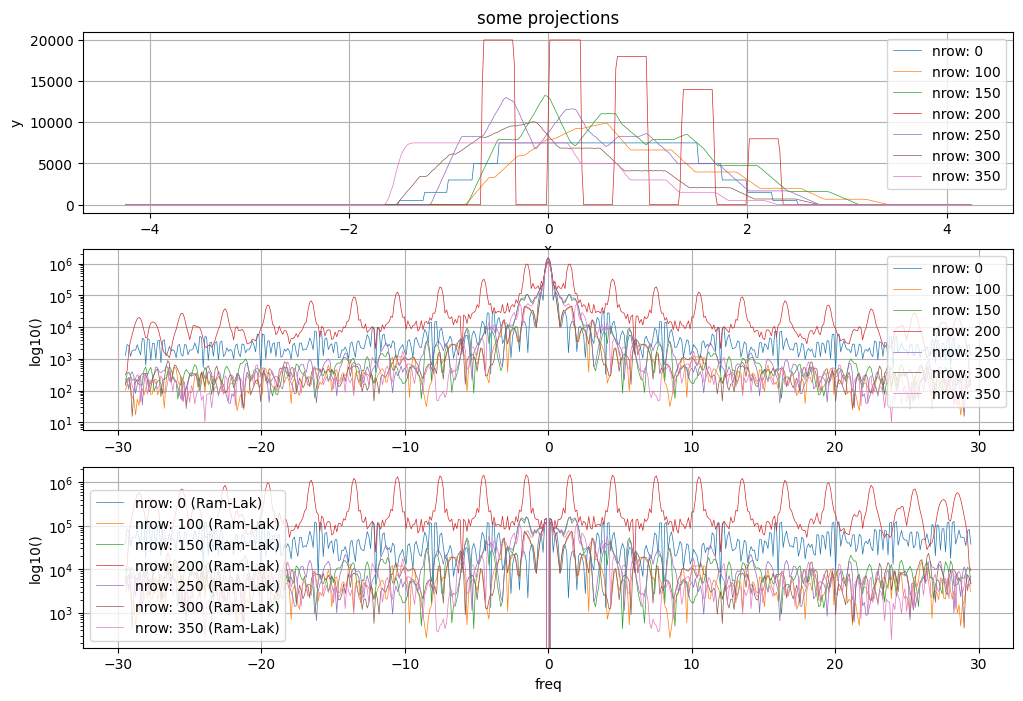

In [4]:
# plotting a projection (fixed angle; all t values)
nrows = [0, 100, 150, 200, 250, 300, 350] # defines all angles for which projections shall be displayed
ds = (t_vec[-1]-t_vec[0])/len(t_vec) # sampling spacing
f_fft = np.fft.fftshift(np.fft.fftfreq(sinogram.shape[1], d=ds))

# the Ram Lak filter in the frequency domain and time domain
# H_ram_lak = np.abs(f_fft)
H_ram_lak = np.abs(np.fft.fftfreq(sinogram.shape[1], d=ds))
# the impulse response
imp_ram_lak = np.real(np.fft.ifft(H_ram_lak))

H_sin_ram_lak = np.fft.fftshift(np.fft.fftshift(H_ram_lak) * np.abs(np.sin(2 * np.pi * np.arange(len(H_ram_lak)) / len(H_ram_lak))))

fig1 = plt.figure(1, figsize=[12, 8])
ax_f11 = fig1.add_subplot(3, 1, 1)
for nrow in nrows:
    ax_f11.plot(t_vec, sinogram[nrow, :], linewidth=0.5, label=f"nrow: {nrow}")
ax_f11.grid(True)
ax_f11.set_ylabel('y')
ax_f11.set_xlabel('x')
ax_f11.legend()
ax_f11.set_title('some projections')

ax_f12 = fig1.add_subplot(3, 1, 2)
for nrow in nrows:
    dft_projection = np.fft.fftshift(np.fft.fft(sinogram[nrow, :]))
    ax_f12.semilogy(f_fft, np.abs(dft_projection), linewidth=0.5, label=f"nrow: {nrow}")
ax_f12.grid(True)
ax_f12.set_ylabel('log10()')
ax_f12.legend()
#ax_f12.set_title('DFTs of a projections');

ax_f13 = fig1.add_subplot(3, 1, 3)
for nrow in nrows:
    dft_projection = np.fft.fftshift(np.fft.fft(sinogram[nrow, :]) * H_ram_lak)
    ax_f13.semilogy(f_fft, np.abs(dft_projection), linewidth=0.5, label=f"nrow: {nrow} (Ram-Lak)")
ax_f13.grid(True)
ax_f13.set_ylabel('log10()')
ax_f13.set_xlabel('freq')
ax_f13.legend()


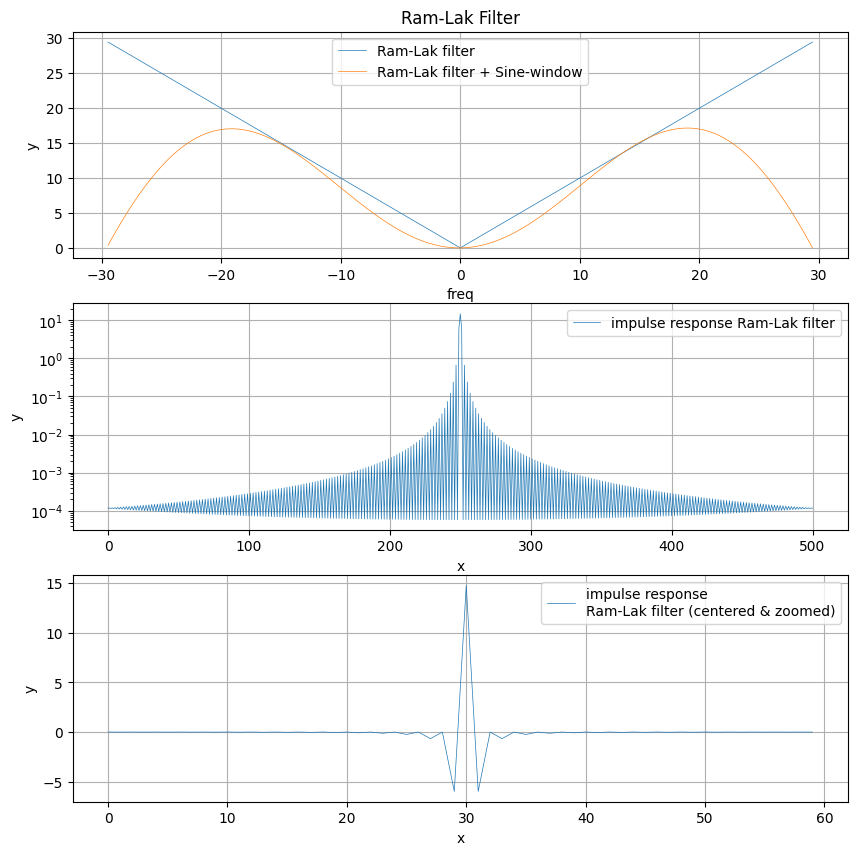

In [5]:
fig2 = plt.figure(2, figsize=[10, 10])
ax_f21 = fig2.add_subplot(3, 1, 1)
ax_f21.plot( f_fft, np.fft.fftshift(H_ram_lak), linewidth=0.5, label=f"Ram-Lak filter")
ax_f21.plot( f_fft, np.fft.fftshift(H_sin_ram_lak), linewidth=0.5, label=f"Ram-Lak filter + Sine-window")
ax_f21.grid(True)
ax_f21.set_ylabel('y')
ax_f21.set_xlabel('freq')
ax_f21.legend()
ax_f21.set_title('Ram-Lak Filter')

ax_f22 = fig2.add_subplot(3, 1, 2)
ax_f22.semilogy(np.fft.fftshift(np.abs(imp_ram_lak)), linewidth=0.5, label=f"impulse response Ram-Lak filter")
#ax_f22.plot(imp_ram_lak[0:20], linewidth=0.5, label=f"impulse response Ram-Lak filter")
ax_f22.grid(True)
ax_f22.set_ylabel('y')
ax_f22.set_xlabel('x')
ax_f22.legend()

ax_f23 = fig2.add_subplot(3, 1, 3)
ax_f23.plot(np.fft.fftshift(imp_ram_lak)[220:280], linewidth=0.5, label="impulse response \nRam-Lak filter (centered & zoomed)")
ax_f23.grid(True)
ax_f23.set_ylabel('y')
ax_f23.set_xlabel('x')
ax_f23.legend()


## A filtered Sinogram

Each projection (row) of the sinogram is transformed to frequency domain, filtered by Ram-Lak filter and transformed back into signal domain.

In [6]:
# initialize filtered sinogram
sinogram_f = np.zeros_like(sinogram)
nc = sinogram.shape[1]
if (nc % 2) == 1:
    n2 = (nc - 1) // 2
else:
    sys.exit('not implemented for even numbers')

# for each projection angle filter in frequency domain and transform back to signal space
for row in range(sinogram.shape[0]):
    sinogram_row = sinogram[row, :]
    sino_f_tmp = np.real(np.fft.ifft(np.fft.fft(np.fft.fftshift(sinogram_row)) * H_ram_lak))
    sinogram_f[row, :] = np.fft.fftshift(sino_f_tmp)


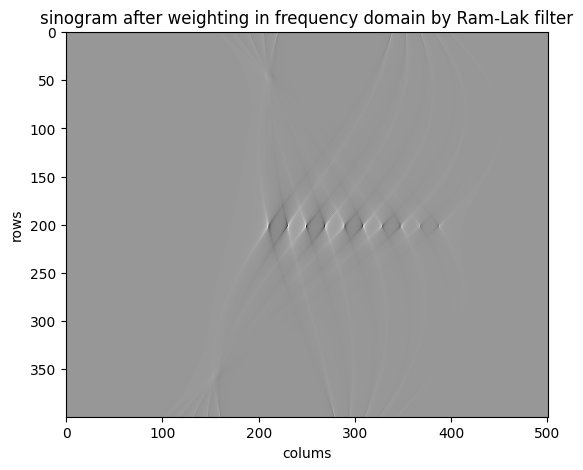

In [7]:
fig3 = plt.figure(3, figsize=[7, 5])
ax_f31 = fig3.add_subplot(1, 1, 1)
# plot of image
ax_f31.imshow(sinogram_f, cmap='Greys' )
ax_f31.set_ylabel('rows')
ax_f31.set_xlabel('colums')
ax_f31.set_title('sinogram after weighting in frequency domain by Ram-Lak filter');

## Reconstruction by Backprojection



In [8]:
# bounding box of image
x_min = t_vec[0]
x_max = t_vec[-1]
y_min = x_min
y_max = x_max

# nr pixels of image
Nx = 800
Ny = 800
x_vec = np.linspace(x_min, x_max, Nx)
y_vec = np.linspace(y_min, y_max, Ny)


In [9]:
# initialise 
img_fbp = np.zeros( (Ny, Nx), dtype=np.float64)
yv = np.flip(y_vec)

# iterate over angles
for theta_index, theta_deg in enumerate(theta_vec_deg):
    phi_rad = math.radians(theta_deg)
    cos_v = math.cos(phi_rad)
    sin_v = math.sin(phi_rad)

    # iterate over image rows
    for nr in range(Ny):
        yval = yv[nr]
        t_values = x_vec * cos_v + yval * sin_v

        sino_theta = sinogram_f[theta_index, :]
        # interpolate
        proj_i = np.interp(t_values, t_vec, sino_theta, left=0, right=0)
        img_fbp[nr, :] = img_fbp[nr, :] + proj_i

In [10]:
print(f"np.min(img_fbp): {np.min(img_fbp)}; np.max(img_fbp): {np.max(img_fbp)}")

np.min(img_fbp): -525586.7969967091; np.max(img_fbp): 1278422.0232389867


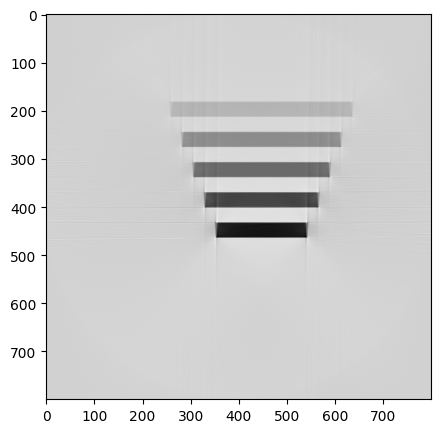

In [11]:
fig5 = plt.figure(5, figsize=[7, 5])
ax_f51 = fig5.add_subplot(1, 1, 1)
# plot of image
ax_f51.imshow(img_fbp, cmap='Greys' )

In [12]:
fname_sino = './sinograms/sinogram_trees.npz'
npzData = np.load(fname_sino)
print(f"npzData.files: {npzData.files}")

npzData.files: ['N_theta', 'theta_vec_deg', 't_vec', 'sinogram']


In [13]:

# get data and initialize filtered sinogram
N_theta = npzData['N_theta']
theta_vec_deg = npzData['theta_vec_deg']
t_vec = npzData['t_vec']
sinogram = npzData['sinogram']
np.nan_to_num(sinogram, copy=False)

# H_ram_lak = np.abs(f_fft)
ds = (t_vec[-1]-t_vec[0])/len(t_vec) # sampling spacing
nrows, ncols = sinogram.shape
H_ram_lak = np.abs(np.fft.fftfreq(ncols, d=ds))

# bounding box of image
x_min = t_vec[0]
x_max = t_vec[-1]
y_min = x_min
y_max = x_max

# nr pixels of image
Nx = 2000
Ny = 1500

img_fbp2, sinogram_f2 = backprojection2(sinogram, x_min, x_max, y_min, y_max, Nx, Ny, t_vec, theta_vec_deg, filter=H_ram_lak)

#img_fbp2 = img_fbp2 - np.min(img_fbp2)
#img_fbp2 = 255 * img_fbp2 / np.max(img_fbp2)

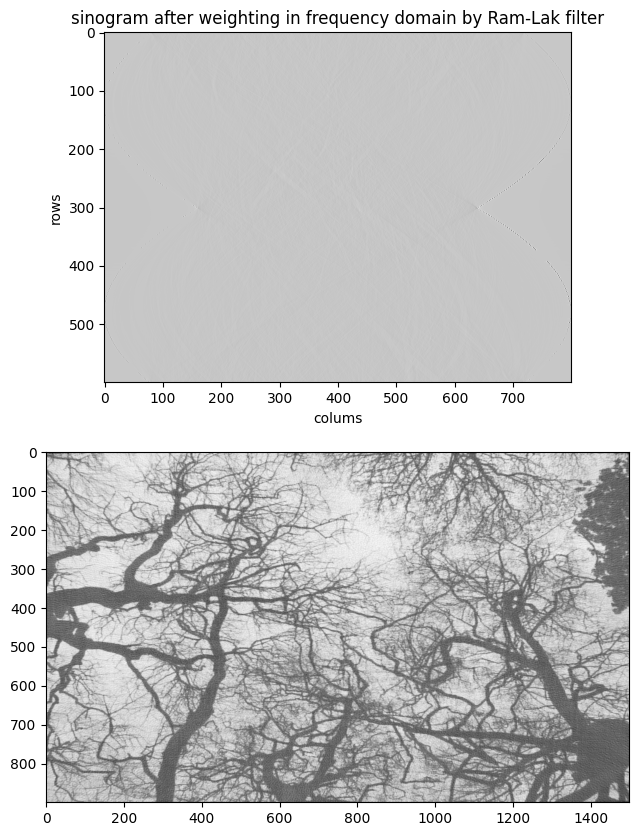

In [14]:
fig6 = plt.figure(6, figsize=[10, 10])
ax_f61 = fig6.add_subplot(2, 1, 1)
# plot of image
ax_f61.imshow(sinogram_f2, cmap='Greys' )
ax_f61.set_ylabel('rows')
ax_f61.set_xlabel('colums')
ax_f61.set_title('sinogram after weighting in frequency domain by Ram-Lak filter');

ax_f62 = fig6.add_subplot(2, 1, 2)
# plot of image
ax_f62.imshow(img_fbp2[300:1200, 250:1750], cmap='Greys_r')


In [15]:
fname_sino = './sinograms/sinogram_lamp.npz'
npzData = np.load(fname_sino)
print(f"npzData.files: {npzData.files}")

npzData.files: ['N_theta', 'theta_vec_deg', 't_vec', 'sinogram']


In [16]:
# get data and initialize filtered sinogram
N_theta = npzData['N_theta']
theta_vec_deg = npzData['theta_vec_deg']
t_vec = npzData['t_vec']
sinogram = npzData['sinogram']
np.nan_to_num(sinogram, copy=False)

sinogram = sinogram - np.min(sinogram)

# H_ram_lak = np.abs(f_fft)
ds = (t_vec[-1]-t_vec[0])/len(t_vec) # sampling spacing
nrows, ncols = sinogram.shape
H_ram_lak = np.abs(np.fft.fftfreq(ncols, d=ds))

# bounding box of image
x_min = t_vec[0]
x_max = t_vec[-1]
y_min = x_min
y_max = x_max

# nr pixels of image
Nx = 1000
Ny = int(Nx * ncols / nrows)

img_fbp3, sinogram_f3 = backprojection2(sinogram, x_min, x_max, y_min, y_max, Nx, Ny, t_vec, theta_vec_deg, filter=H_ram_lak)

#img_fbp3 = img_fbp3 - np.min(img_fbp3)
#img_fbp3 = 255 * img_fbp3 / np.max(img_fbp3)

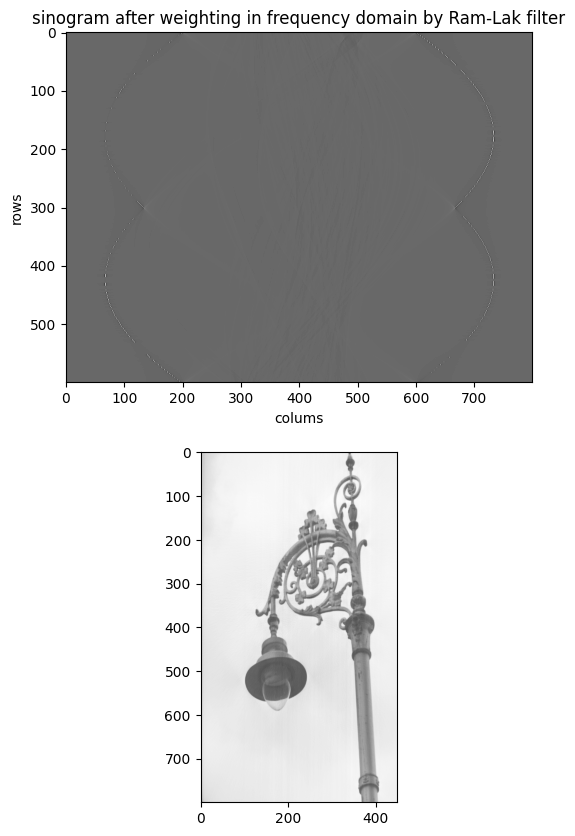

In [17]:
fig7 = plt.figure(7, figsize=[10, 10])
ax_f71 = fig7.add_subplot(2, 1, 1)
# plot of image
ax_f71.imshow(sinogram_f3, cmap='Greys_r' )
ax_f71.set_ylabel('rows')
ax_f71.set_xlabel('colums')
ax_f71.set_title('sinogram after weighting in frequency domain by Ram-Lak filter');

ax_f72 = fig7.add_subplot(2, 1, 2)
# plot of image
ax_f72.imshow(img_fbp3[300:1100,250:700], cmap='Greys_r')

In [18]:
np.min(img_fbp3[300:1100,250:700]), np.max(img_fbp3[300:1100,250:700])


(-6905857.651108878, 12215343.059351148)